# Basic Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import Counter
import numpy as np
from spacy.lang.en import English
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

nlp = English()

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
colWidth = pd.get_option('display.max_colwidth')

# Class and function definitions

In [4]:
class Corpus:
    def __init__(self, filePath, maxTokens):
        self.bagOfWords = Counter()
        self.listOfWords = ["removeMe"]  # So that the list is not empty
        self.wordInDocIndex = np.zeros(1, dtype=int)  # So that array is not empty
        self.docLen = list()
        self.numDocs = 0
        docNumber = 0
        numActualToken = 0
        train_data = pd.read_csv(filePath)
        X = train_data.text.tolist()
        for doc in X:
            self.numDocs += 1
            tokens = doc.lower().split()
            numActualToken += len(tokens)
            numTokenTemp = 0
            for iToken in tokens:
                if not nlp.vocab[iToken].is_stop and iToken not in ['.', '&', '...', '-', ';', '/', '!', ',', '(', "[", "]", '’', '%',
                                                                    ')', "'", '"', ':', "?", '``',
                                                                    '....'] and not iToken.isdigit():
                    self.bagOfWords[iToken] += 1
                    self.listOfWords = self.listOfWords + [iToken]
                    numTokenTemp += 1
            self.docLen.append(numTokenTemp)
            tempArray = docNumber * np.ones(numTokenTemp, dtype=int)
            self.wordInDocIndex = np.concatenate((self.wordInDocIndex, tempArray), axis=None)
            docNumber += 1
            if numActualToken >= maxTokens + 1:
                self.listOfWords.pop(0)  # Removed "removeMe"
                self.wordInDocIndex = np.delete(self.wordInDocIndex, 0)
                break

    def most_common_word(self, numOfMostCommonWords):
        self.corpusMostCommonWords = Counter(self.bagOfWords).most_common(numOfMostCommonWords)


class IntegerVocabulary:
    def __init__(self, mostCommonWords, maxVocabSize):
        self.integerVocab = dict()  # Changed from list to dict - See assignment 1
        wordCode = 0
        for iWord in range(maxVocabSize):
            self.integerVocab[mostCommonWords[iWord][0]] = wordCode
            wordCode += 1


In [5]:
def estimateDocTopicProb(docId):
    numerator = docTopicFreq[docId] + topicParameter
    denominator = books.docLen[docId] - 1 + numTopics * topicParameter
    return numerator / denominator


def estimateTopicWordProb(wordIndex, prevWordIndex):
    numerator = bigramTopicFreq[wordIndex, prevWordIndex] + dirParameter
    sumWordsinToken = np.sum(wordTopicFreq, axis=0)
    denominator = sumWordsinToken + numUniqueWords * dirParameter
    return numerator / denominator


def estimateTopicWordProbUnPairedWords(wordIndex):  # The first words don't have preceeding word so this function is
    # picked from task 1 of this assignment.
    numerator = wordTopicFreq[wordIndex] + dirParameter
    sumWordsinToken = wordTopicFreq.sum(axis=0)
    denominator = sumWordsinToken + numUniqueWords * dirParameter  # Need to check if should be commented or included.
    return numerator / denominator

**Variable Defifnition**

In [6]:
filePath = "/content/drive/My Drive/MLNLP/FinalAssignment/train.csv"

In [7]:
maxGibbsIterations = 100
maxTokens = 100000
desiredWordsToBePrinted = 20

In [8]:
books = Corpus(filePath, maxTokens)
maxTokens = len(books.listOfWords)
numUniqueWords = len(books.bagOfWords)
numDocs = len(books.docLen)

maxVocabSize = numUniqueWords
numOfMostCommonWords = maxVocabSize  # Not considering padding and out-of-vocabulary - See assignment 1
books.most_common_word(numOfMostCommonWords)
booksIV = IntegerVocabulary(books.corpusMostCommonWords, maxVocabSize)

In [9]:
documentTopicsDF = pd.DataFrame()
figureNum = 0
numTopicsList = [5]
parameterList = [(0.01, 0.01)]

wordTopicResultsT1 = list()
sumWordsinTokenResultsT1 = list()

# Execution loop

In [10]:
iCase = 0
for iTopicList in range(len(numTopicsList)):
    for iParameterList in range(len(parameterList)):
        print(iCase, end=" ")
        numTopics = numTopicsList[iTopicList]
        dirParameter = parameterList[iParameterList][0]
        topicParameter = parameterList[iParameterList][1]

        wordTopicResultsT1.append(list())
        sumWordsinTokenResultsT1.append(np.zeros(numTopics))

        wordTopic = np.random.randint(0, numTopics, maxTokens)
        wordTopicFreq = np.zeros((numUniqueWords, numTopics), dtype=int)

        docId = np.arange(0, numDocs, 1)
        docTopicFreq = np.zeros((numDocs, numTopics), dtype=int)

        # Random initialization matrix updates
        jDocId = 0
        for iNumber, iWord in enumerate(books.listOfWords):
            wordIdentity = booksIV.integerVocab[iWord]
            wordTopicFreq[wordIdentity, wordTopic[iNumber]] += 1
            jDocId = books.wordInDocIndex[iNumber]
            docTopicFreq[jDocId, wordTopic[iNumber]] += 1

        iGibbs = 0
        while iGibbs < maxGibbsIterations:
            print(iGibbs)
            iGibbs += 1
            iDocId = 0
            for iNumber, iWord in enumerate(books.listOfWords):
                topicNumber = wordTopic[iNumber]
                wordIdentity = booksIV.integerVocab[iWord]
                wordTopicFreq[wordIdentity, topicNumber] -= 1
                iDocId = books.wordInDocIndex[iNumber]
                docTopicFreq[iDocId, topicNumber] -= 1
                docTopicProb = estimateDocTopicProb(iDocId)
                wordTopicProb = estimateTopicWordProbUnPairedWords(
                    wordIdentity)  # Notice we have passed the integer index
                probWordInToken = np.multiply(docTopicProb, wordTopicProb)
                selectedTopic = np.random.multinomial(1, probWordInToken / probWordInToken.sum()).argmax()
                wordTopicFreq[booksIV.integerVocab[iWord], selectedTopic] += 1
                docTopicFreq[iDocId, selectedTopic] += 1
                wordTopic[iNumber] = selectedTopic

        wordTopicResultsT1[iCase] = wordTopic
        sumWordsinTokenResultsT1[iCase] = wordTopicFreq.sum(axis=0)
        iCase += 1


0 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Results

The next cell contains all the infomartion required to analyse results and draw conclusions. The cell contains 1 figure and 2 tables each for one of the 4 cases. The figure represents the fraction of words present in the topic as compared to total number of words considered for execution. The two tables represents words in each topic and words in the dominant topic of each document. Both the tables are trimmed to display 5 top topics and 15 documents respectively.

In general, the abstract format of output is figure, top 5 topics table and dominant topic in document table.

The table with top 5 topics portrays words that settled in topic by raw count, relative count and a mixture of raw and relative count. Raw count implies the words that are dominant within the topic, relative implies the words that are unique within corpus but ended under the highlighted topic and "relraw" implies the words first sorted based on raw count and then top 20 words were picked which were sorted by their relative count in the corpus. 

The table related to documents and dominant topic in the document goes through every document and looks for the topic that is dominant within the document and prints how much percentage of document exists in the topic and some of the words in this intersection. 

The observations are explained after printing all the outputs below.

Case 1, α = 0.01, β = 0.01, K = 5




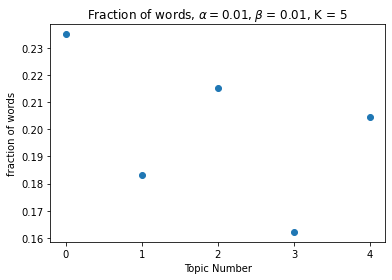

0          1              2           3         4   \
Topic 3 Raw             black       like         people          ''       red   
        Rel         tennessee  basically          9-1-1     colbert     march   
        RelRaw          trans        red         mental      auntie    matter   
Topic 1 Raw                ''       like         people        said      skin   
        Rel           pointed       owns     ejaculated       lower      risk   
        RelRaw           skin      light             na       girls     found   
Topic 4 Raw                ''       wife           like      people      love   
        Rel       classifieds  available         brings  collection  agencies   
        RelRaw          night       kids          right       going     world   
Topic 2 Raw                ''       wife           said        like       man   
        Rel     *elevennessee      room*  advertisement    delivery  'trabajo   
        RelRaw           word       tell           said         old     asked   
Topic 0 Raw                ''     people           like       black      love   
        Rel          inserted   received           step       roses  weddings   
        RelRaw            gay       need            let        says       way   

                        5            6          7            8           9   \
Topic 3 Raw         mental        white       time        trans       tweet   
        Rel          civil  involuntary     square         root        -100   
        RelRaw       tweet          tea      black        white      health   
Topic 1 Raw           know       health       want        women  difference   
        Rel       prostate      harvard        t.h      virgins       kills   
        RelRaw  difference       change      women       health         men   
Topic 4 Raw           time         good       want          day        life   
        Rel             ma        extra  curricula   activities       shape   
        RelRaw        girl         good       told         love        wife   
Topic 2 Raw           time       people        day          got        told   
        Rel        spanish        latin       term  'trepaliare     meaning   
        RelRaw         man         told      right         wife          ''   
Topic 0 Raw           know         wife        gay          way        said   
        Rel       funerals         cake   enrolled     schedule     exposed   
        RelRaw         new         best        guy         love        know   

                       10          11            12          13       14  \
Topic 3 Raw           day      health           new         got   matter   
        Rel     imaginary      select           tin        pang   relief   
        RelRaw      happy         new          need         got      day   
Topic 1 Raw          love       girls         found        wife    light   
        Rel       streets    shouting  disobedience     72-hour  granted   
        RelRaw       like        said          know       think     want   
Topic 4 Raw         night       going         right        know     told   
        Rel      weekends  after-work     obsession      rubble     dial   
        RelRaw      think        time          want         day     life   
Topic 2 Raw          know        want          tell       asked    right   
        Rel       torture     trapped    earthquake  identified  heroine   
        RelRaw      woman        time           got         day     good   
Topic 0 Raw          need        life           let         new     want   
        Rel       blindly        chan         frida       grief  honesty   
        RelRaw     people       going         black        life       ''   

                     15         16        17          18         19  
Topic 3 Raw      auntie        tea      need       happy       life  
        Rel        mole     dollop      fuel     systems       belt  
        RelRaw     like     people    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide


,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
1507,1507,2.0,1.0,"[fat, babies, born, earlier, running, womb]"
3241,3241,0.0,1.0,"[chinese, nazis, wongs, reich]"
1820,1820,3.0,1.0,"[dr., sarah, vinson, psychiatrist, executive, editor, black, magazine, culturally, tailored, online, print, product, focuses, black, mental, healt..."
1822,1822,2.0,1.0,[says]
1824,1824,0.0,1.0,"[male, squirrels, gay, cuz, love, nuts]"
1825,1825,2.0,1.0,"[need, gift, man, try, giving, scornful, look]"
3243,3243,3.0,1.0,"[excited, autopsy, club, evening, open, mike, night]"
1827,1827,1.0,1.0,"[men, arguing, known, jews, israelis, hebrews, arguing, semitics]"
1828,1828,4.0,1.0,"[lord, help, remember, going, happen, today, handle, amen]"
3240,3240,4.0,1.0,"[hello, sir, internet, provider, recently, said, homosexuality, wrong, '', blocked, seeing, lesbian, porn]"


In [11]:
# Results
topTopicsSize = 5
iCase = 0
for iTopicList in range(len(numTopicsList)):
    for iParameterList in range(len(parameterList)):
        numTopics = numTopicsList[iTopicList]
        dirParameter = parameterList[iParameterList][0]
        topicParameter = parameterList[iParameterList][1]

        print("Case %d, \u03B1 = %.2f, \u03B2 = %.2f, K = %d\n\n" % (iCase + 1, topicParameter, dirParameter, numTopics))

        # Result part - 1. Plots
        sumWordsinToken = sumWordsinTokenResultsT1[iCase].copy()
        figureNum += 1
        ax = plt.figure(figureNum).gca()
        plt.scatter(np.arange(0, numTopics), sumWordsinToken / maxTokens)
        plt.xlabel("Topic Number")
        plt.ylabel("fraction of words")
        plt.title(r"Fraction of words, $\alpha = {}, \beta$ = {}, K = {}".format(str(topicParameter), str(dirParameter),
                                                                                 str(numTopics)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

        # Result part - 2
        topicWordRelationByRawCount = list()
        topicWordRelationByRelativeCount = list()
        topicWordRelationByRelInMaxRaw = list()
        for iTopic in range(numTopics):
            topicWordRelationByRawCount.append(Counter())
            topicWordRelationByRelInMaxRaw.append(Counter())

        for iNumber, iWord in enumerate(books.listOfWords):
            topicWordRelationByRawCount[wordTopicResultsT1[iCase][iNumber]][iWord] += 1

        for iTopic in range(numTopics):
            topicWordRelationByRelativeCount.append(topicWordRelationByRawCount[iTopic].copy())

        for iTopic in range(numTopics):
            for iWord in topicWordRelationByRawCount[iTopic].keys():
                temp = topicWordRelationByRawCount[iTopic][iWord]
                topicWordRelationByRelativeCount[iTopic][iWord] = temp / books.bagOfWords[
                    iWord]

        for iTopic in range(numTopics):
            tempDict = [topicWordRelationByRawCount[iTopic], topicWordRelationByRelativeCount[iTopic]]
            for iWord in topicWordRelationByRawCount[iTopic].keys():
                topicWordRelationByRelInMaxRaw[iTopic][iWord] = tuple(i[iWord] for i in tempDict)

        backupRel = list()
        for iTopic in range(numTopics):
            backupRel.append(topicWordRelationByRelativeCount[iTopic].copy())

        for iTopic in range(numTopics):
            topicWordRelationByRawCount[iTopic] = sorted(topicWordRelationByRawCount[iTopic].items(),
                                                         key=lambda x: x[1],
                                                         reverse=True)
            topicWordRelationByRelativeCount[iTopic] = sorted(topicWordRelationByRelativeCount[iTopic].items(),
                                                              key=lambda x: x[1], reverse=True)
            topicWordRelationByRelInMaxRaw[iTopic] = sorted(topicWordRelationByRelInMaxRaw[iTopic].items(),
                                                            key=lambda x: x[1][0], reverse=True)

        maxWordsCanBePrinted = list()
        for iMax in range(numTopics):
            maxWordsCanBePrinted.append(len(topicWordRelationByRawCount[iMax]))

        numWordsToPrint = list()
        for iMin in range(numTopics):
            numWordsToPrint.append(min(maxWordsCanBePrinted[iMin], desiredWordsToBePrinted))
            topicWordRelationByRelInMaxRaw[iMin] = topicWordRelationByRelInMaxRaw[iMin][:numWordsToPrint[iMin]]
            topicWordRelationByRelInMaxRaw[iMin] = sorted(topicWordRelationByRelInMaxRaw[iMin],
                                                          key=lambda x: x[1][1], reverse=True)

        uniqueWordsinToken = [len(topicWordRelationByRelativeCount[iTopic]) for iTopic in range(numTopics)]
        uniqueWordsinToken = np.array(uniqueWordsinToken)

        topTopics = sumWordsinToken.argsort()[numTopics - topTopicsSize:]
        listHeader = ["removeMe"]
        for i in range(len(topTopics)):
            listHeader = listHeader + ["Topic {}".format(topTopics[i])]
        listHeader.pop(0)
        colHeaders = pd.MultiIndex.from_product([listHeader, ['Raw', 'Rel', 'RelRaw']])
        resultTopicDF = pd.DataFrame()
        # for iDFRow in range(min(numWordsToPrint)): # For all topics
        for iDFRow in range(desiredWordsToBePrinted):
            tempRow = list()
            for iDFCell in range(len(topTopics)):
                try:
                    tempRow.append(topicWordRelationByRawCount[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
                try:
                    tempRow.append(topicWordRelationByRelativeCount[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
                try:
                    tempRow.append(topicWordRelationByRelInMaxRaw[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
            tempDF = pd.DataFrame([tempRow])
            if len(tempRow) > 0:
                resultTopicDF = resultTopicDF.append(tempDF, ignore_index=True)
            tempRow.clear()
        resultTopicDF.columns = colHeaders
        display(resultTopicDF.head(desiredWordsToBePrinted).transpose())

        print("\n\n")

        # Result part - 3. Works fine(Hopefully)
        topicCount = list()
        topicCountPerc = list()
        maxTopicNumPerc = np.zeros((numDocs, 2), dtype=float)
        wordsInMaxTopic = list()
        iPosition = 0
        jPosition = 0
        for iDoc in range(numDocs):
            topicCountPerc.append(np.zeros(numTopics, dtype=float))
            topicCount.append(np.zeros(numTopics, dtype=int))
            wordsInMaxTopic.append(list())

            for iWord in range(jPosition, jPosition + books.docLen[iDoc]):
                topicCount[iDoc][wordTopicResultsT1[iCase][iWord]] += 1
            jPosition += books.docLen[iDoc]
            topicCountPerc[iDoc] = topicCount[iDoc] / books.docLen[iDoc]

            maxTopicNumPerc[iDoc][0] = int(topicCount[iDoc].argmax())
            maxTopicNumPerc[iDoc][1] = max(topicCountPerc[iDoc])

            for iWord in range(iPosition, iPosition + books.docLen[iDoc]):
                if wordTopicResultsT1[iCase][iWord] == maxTopicNumPerc[iDoc][0]:
                    wordsInMaxTopic[iDoc].append(books.listOfWords[iWord])
            iPosition += books.docLen[iDoc]

        documentTopicsDF = pd.DataFrame()

        documentTopicsDF.insert(0, "Document Number", np.arange(0, numDocs, 1))
        documentTopicsDF.insert(1, "Dominant Topic", maxTopicNumPerc[:, 0])
        documentTopicsDF.insert(2, "Percentage", maxTopicNumPerc[:, 1])
        documentTopicsDF.insert(3, "Words In Dominant Topic", wordsInMaxTopic)
        documentTopicsDF = documentTopicsDF.sort_values("Percentage", ascending=False)
        pd.set_option('display.max_colwidth', 150)
        documentTopicsDF.style.hide_index()
        display(documentTopicsDF.head(15))
        pd.set_option('display.max_colwidth', colWidth)
        
        print("\n\n")
        iCase += 1


Considering one example from case 4, the output seems logical because Topic 9 from Document 15 seems to have words related to drugs which haven't occured frequently in the other parts of that document and so it is not under dominant topics.
